In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import utils_aruco
import utils_icp
import copy
from utils_data_process import *
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.image as mpimg
from scipy.optimize import curve_fit

data_folder = './data-raw'
# plt.rcParams['mathtext.fontset'] = 'custom'

plt.rcParams['mathtext.default'] = 'regular'  # Use regular text for mathtext by default
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

# Optionally, you can also set the default font family to Arial for consistency
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fontsize_main = 20
fontsize_legend = 14
# import sys
# import importlib
# importlib.reload(sys.modules['utils_data_process'])



In [2]:
tags = [3, 4, 10, 5]

tag_mapping = {}

regulator_mapping = {}

for i in range(4): # 4 regulators
    regulator_mapping[i] = ["regulator_PWM" + str((2*i +1 )), "regulator_PWM" + str((2*i + 2))]

for i in range(len(tags)):
    tag_mapping[i] = tags[i]
    
result_name_arr = [
    
    "/Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic",
]

tag_offset_dict = {
    3: {
        'rot': 180,
        'disp': [-3.25, 3.25]
    }
}

ids = [4, 2, 3, 10, 5] # maps to base, joint 0, joint 1, joint 2, joint 3, joint 4

base_tag_arr = [2]
tag_size_arr = [4]

values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr = multi_data_prep(data_folder, 
                                                                                                           result_name_arr, 
                                                                                                           ids,
                                                                                                           base_tag_arr,
                                                                                                           tag_size_arr,
                                                                                                           tag_offset_dict=tag_offset_dict)

found prior buffer, loading from /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/load_data.pkl
dict_keys(['values_dict', 'times_dict', 'camera_dict'])
Image already exists at /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/frame_1.png. Skipping...
Image already exists at /Volumes/WD 500GB/test_20240820_16-14-01_act_1_kinematic/processed/frame_1000.png. Skipping...
loaded keys:  ['camera_3', 'camera_4', 'camera_5', 'camera_2', 'camera_10', 'camera_time', 'regulator_PWM1', 'regulator_PWM2', 'regulator_PWM3', 'regulator_PWM4', 'regulator_PWM5', 'regulator_PWM6', 'regulator_PWM7', 'regulator_PWM8', 'regulator_PWM9', 'regulator_PWM10', 'regulator_PWM11', 'regulator_PWM12', 'info_CYCLE_DONE', 'camera_37', 'camera_17']
dict_keys(['disp', 'rot', 't', 'corners_len', 'angle_wrt_fixed', 'centroid', 'corners', 'disp_offset', 'rot_offset', 'centroid_offset', 'corners_offset'])


n cycle 5 cycle len 200
{3: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 4: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 5: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 2: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463]), 10: array([  45.91842246,   46.03290772,   46.26157928, ..., 1546.87562156,
       1547.06934786, 1547.27325463])}
fitted circle: x 696.23 y 584.68 r 81.08 sigma 0.80
fitted circle: x 4.80 y -7.49 r 11.68 sigma 0.09
angles -85.91933148337156 274.0514409679553
start_idx: 1504, end_idx: 3005
top_y_mask: [ True  True  True ... False False False], bot_y_mask: [False False False ...  True  True  True]
top_y: [-33.36459    -32.5002     -33.517887   -34.31875    -34.301
 -35.10843    -34.19156    -34.19156    -33.382744 

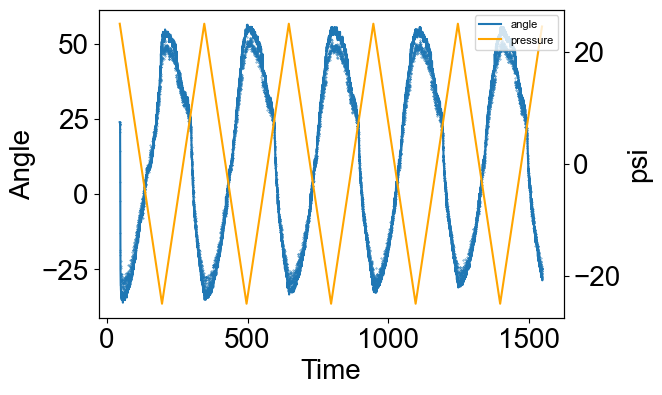

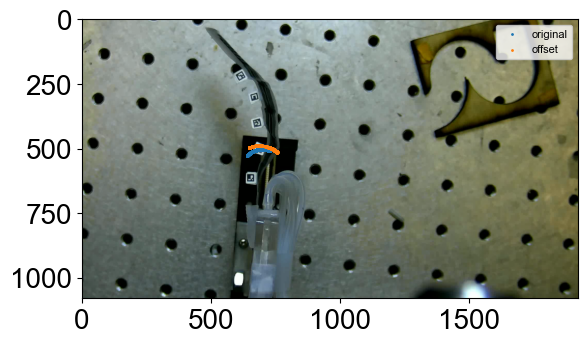

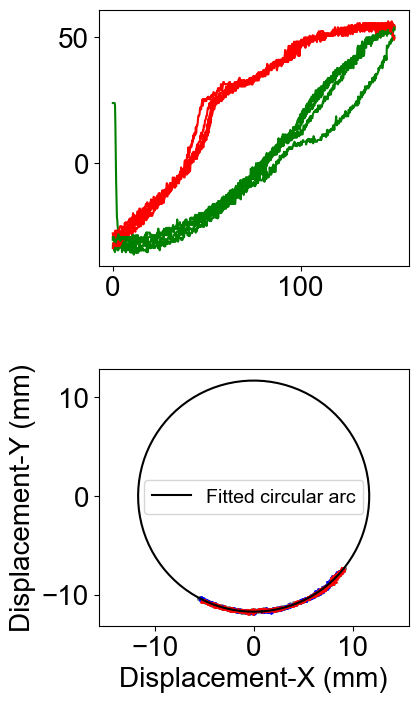

In [4]:
from utils_data_process import *

index_of_tag = 0
index_of_actuator = 0
n_cycle = 5
base_angle = 0

plt.rcParams['font.size'] = fontsize_main
tag_of_desired = tag_mapping[index_of_tag]

lines = []
lines_circle = []
fig, ax_ori = plt.subplots(1, 1, figsize=(6,4))
fig, ax_img = plt.subplots()
fig, ax_angle = plt.subplots(2, 1, figsize=(4,8), sharey='row',gridspec_kw={'wspace': 0.14, 'hspace': 0.4})

img = mpimg.imread(os.path.join(data_folder, result_name_arr[0], 'processed', 'frame_1.png'))
ax_img.imshow(img)

for ii, (values_dict, times_dict, camera_dict, camera_data_dict, camera_scale) in enumerate(zip(values_dict_arr, times_dict_arr, camera_dict_arr, camera_data_dict_arr, camera_scale_arr)):
    
    r_val = merge_PWM(values_dict[regulator_mapping[index_of_actuator][0]], values_dict[regulator_mapping[index_of_actuator][1]])
    r_time = times_dict[regulator_mapping[index_of_actuator][0]]

    cycle_len = prep_cycle(n_cycle, camera_data_dict, r_val, r_time)

    ax = ax_img
    ax.scatter(
            camera_data_dict['centroid'][tag_of_desired][:, 0], 
            camera_data_dict['centroid'][tag_of_desired][:, 1], 
            linestyle='-',
            # label=f'Trial {i+1}',
            s=1,
            label = "original"
        )
    if tag_of_desired in tag_offset_dict:
        ax.scatter(
                camera_data_dict['centroid_offset'][tag_of_desired][:, 0], 
                camera_data_dict['centroid_offset'][tag_of_desired][:, 1], 
                linestyle='-',
                # label=f'Trial {i+1}',
                s=1,
                label = "offset"
            )
    ax.legend(loc = 1, prop= {"size": 8})
    ax = ax_ori
    ax.scatter(camera_data_dict['t'][tag_of_desired], camera_data_dict['rot'][tag_of_desired], s=0.1)
    ln1 =ax.plot(camera_data_dict['t'][tag_of_desired], camera_data_dict['angle_wrt_fixed'][tag_of_desired], linestyle='-', label = "angle")
    ax.set_xlabel('Time')
    ax.set_ylabel('Angle')
    ax.set_ylim(np.min(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) - 5, np.max(camera_data_dict['angle_wrt_fixed'][tag_of_desired]) + 5)
    ax1 = ax.twinx()
    ln2 = ax1.plot(r_time, r_val, color = "orange", label = "pressure")
    ax1.set_ylabel('psi')

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc = 1, prop={'size': 8})

    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid'][tag_of_desired][:, :2])
    ax.scatter([xc], [yc], s=2)

    # xc, yc, r, sigma, angles = circle_fit(camera_data_dict['centroid_offset'][tag_of_desired][:, :2]  * camera_scale[0])
    # ax.scatter([xc], [yc], s=2)
    xc, yc, r, sigma, angles = circle_fit(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0])
    #circle_error = calc_circle_fit_err(camera_data_dict['disp_offset'][tag_of_desired][:, :2]*camera_scale[0], xc, yc, r)
    #print('circle error', np.sqrt(np.mean(circle_error**2)), np.std(circle_error))

    angles[angles < -1.5] += 2 * np.pi
    camera_data_dict['angle_wrt_fixed'][tag_of_desired][camera_data_dict['angle_wrt_fixed'][tag_of_desired] < -120] += 360

    print('angles', np.rad2deg(np.min(angles)), np.rad2deg(np.max(angles)))

    angle_plot_arr = []
    for i in list(range(1, n_cycle-1))+[0, n_cycle-1] :
        if i == 0:
            color = 'blue'
        elif i == n_cycle-1:
            color = 'red'
        else:
            color = 'grey'
            
        ax = ax_angle[0]    
        # if i != 0:
            # continue
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"start_idx: {start_idx}, end_idx: {end_idx}")
        #t_plot = camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]
        angle_plot = (camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx]-base_angle) #plotting angle vs time
        angle_plot_arr.append(np.copy(angle_plot))
        if i == 0:
            print(len(angle_plot), 'range of angles', np.max(angle_plot) - np.min(angle_plot), np.min(angle_plot), np.max(angle_plot))
        #print(t_plot[-10:])
        angle_plot_arr.append(angle_plot)
        # line = ax.plot(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], 
        #         angle_plot,
        #         linestyle='-',
        #         label=f'#{i+1}',
        #         color=color
        #         ) #plotting angle vs time
        # display(f"angles: {str(angle_plot)}")
        # display(f"time:  {str(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])}")
        # display(f"time:  {str(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])}")
        top_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx])
        top_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][top_mask] - base_angle
        bot_mask = np.isin(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx], camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx])
        bot_y = camera_data_dict['angle_wrt_fixed'][tag_of_desired][start_idx:end_idx][bot_mask] - base_angle
        print(f"top_y_mask: {top_mask}, bot_y_mask: {bot_mask}")
        print(f"top_y: {top_y}, bot_y: {bot_y}")
        #print(camera_data_dict['t_cycle_top'][tag_of_desired])
        line = ax.plot((camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_top'][tag_of_desired][start_idx:end_idx] != -1)]), 
                top_y,
                linestyle='-',
                label=f'#{i+1}',
                color="green"
                ) #plotting angle vs time
        line = ax.plot((camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx][np.where(camera_data_dict['t_cycle_bot'][tag_of_desired][start_idx:end_idx] != -1)]), 
                bot_y,
                linestyle='-',
                label=f'#{i+1}',
                color="red"
                )
        if ii == len(result_name_arr) - 1:
            lines.append(line)

        ax = ax_angle[1]
        start_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i]
        end_idx = camera_data_dict['cycle_start_idx'][tag_of_desired][i+1]
        print(f"xc: {xc}, yc: {yc}")
        ax.scatter(
            (camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 0]*camera_scale[0]-xc),#-base_disp[1], 
            camera_data_dict['disp_offset'][tag_of_desired][start_idx:end_idx, 1]*camera_scale[0]-yc,#-base_disp[0], 
            
            linestyle='-',
            label=f'Trial {i+1}',
            s=1,
            color=color
        )

    #calc_angle_var(angle_plot_arr)
    lines_circle.append(plot_circle_arc(ax, [0, 0], r, np.min(angles), np.max(angles), flip_xy=False))


    ax.legend()
print(lines)
for i, ax in enumerate([ax_angle[0]]):
    #ax.axis('equal')
    ax.set_ylim(-125, 125)
    ax.set_yticks([-100, -50, 0, 50, 100])
    ax.set_yticklabels(['-100', '-50','0',  '50','100'])
    ax.set_xlim(-10, np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])*1.1)
    #map tmime to pressure
    ax.set_xticks([map_range(tmp, -25, 25, 
                            np.min(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx]), 
                            np.max(camera_data_dict['t_cycle'][tag_of_desired][start_idx:end_idx])) for tmp in [-25, -12.5, 0, 12.5, 25]])
    ax.set_xticklabels(['(172,0)', '', '(0,0)', '', '(0,172)'])
    
    #ax.set_title(f'{psi[i]} kPa', fontsize='24')
    #ax.text(0.03, 0.97,f'Middle = {psi[i]} psi', transform=ax.transAxes, verticalalignment='top',  bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
    if i == 0:
        ax.set_ylabel('Angle (°)', )
        ax.set_xlabel('Pressure (kPa)', )
    if i == 0:
        legend_labels = [r'1st trial', r'2-4th trial', '5th trial']
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=lines[i][0].get_color(), markersize=10) for i in [-2, -3, -1]]
        legend = ax.legend(legend_handles, legend_labels, ncol=1, 
                        labelspacing=0.1, 
                        columnspacing =0.05,
                        loc='upper right', 
                        handletextpad=0.1, 
                        fontsize=fontsize_legend
                        )

for i, ax in enumerate([ax_angle[1]]):
    ax.axis('equal')
    #ax.set_xlim(-15, 15)
    #ax.set_xticks([-7.5,-5, -2.5, 0, 2.5, 5, 7.5])
    #ax.set_xticklabels(['', '-5', '', '0', '', '5', '',])
    #ax.set_ylim(0, 30)
    #ax.set_yticks([0, 2.5, 5, 7.5])
    #ax.set_yticklabels(['0', '', '5', '',])
    
    ax.set_aspect('equal')
    if i == 0:
        ax.set_ylabel('Displacement-Y (mm)')
    if i == 0:
        ax.legend(handles=[lines_circle[i][0]], labels=['Fitted circular arc'], fontsize=fontsize_legend,)
    if i == 0:
        ax.set_xlabel('Displacement-X (mm)')

#fig.text(0.06, 0.5, , va='center', rotation='vertical')
# plt.tight_layout()

#plt.savefig(os.path.join(figures_dir, 'onedir-diamond-cont.pdf'), dpi=600)
plt.show()